In [1]:
%load_ext autoreload 
%autoreload 2

import os
import random
from collections import deque
import numpy as np
import scipy.linalg as sl
from PIL import Image
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display

import torch
from torch import nn, distributions as dist, autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, CenterCrop, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, Normalize
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_dtype(torch.float32)
plt.style.use('seaborn-v0_8')

from mnist import MNISTTrain, MNISTTest

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = 28
batch_size = 512
num_classes = 10
zdim = 50

In [3]:
train_ds = MNISTTrain(transform=Compose([
    ToTensor(),
    # RandomHorizontalFlip(0.1),
    # RandomVerticalFlip(0.1),
    Normalize(127., 128.0)
]))
val_ds = MNISTTest(transform=Compose([
    ToTensor(),
    Normalize(127., 128.0)
]))


In [4]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, drop_last=True)

In [5]:
next(iter(train_loader))[0].aminmax()

torch.return_types.aminmax(
min=tensor(-0.9922),
max=tensor(1.))

In [6]:
class Upsample(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, 
                stride=2, padding=0, outpout_padding=0):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, 
                                       out_channels, 
                                       kernel_size=kernel_size, 
                                       stride=stride, 
                                       padding=padding,
                                       output_padding=outpout_padding
                                       )
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        x = F.dropout(x, 0.1)
        return x

class Generator(nn.Module):
    
    def __init__(self, zdim=50):
        super().__init__()
        self.zdim = zdim
        self.dense = nn.Linear(zdim, 7*7*256)
        self.bn1 = nn.BatchNorm1d(7*7*256)
        self.act1 = nn.GELU()
        self.upsample1 = Upsample(256, 128, kernel_size=3, padding=1, stride=1)
        self.upsample2 = Upsample(128, 64, kernel_size=3, padding=1, stride=1)
        self.upsample3 = Upsample(64, 32, kernel_size=3, padding=1, stride=2, outpout_padding=1)
        self.upsample4 =nn.ConvTranspose2d(32, 
                                       1, 
                                       kernel_size=3, 
                                       stride=2, 
                                       padding=1,
                                       output_padding=1
                                       )
        self.normalizer = nn.Tanh()
        
    def forward(self, z):
        x = self.dense(z)
        x = self.bn1(x)
        x = self.act1(x)
        x = x.view((x.size(0),  256, 7, 7,))
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.upsample4(x)
        x = self.normalizer(x)
        return x


class Discriminator(nn.Module):
    
    def __init__(self, ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding="same"),
            # nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            
        
        )

        self.dense = nn.Sequential(
            nn.Linear(256, 96),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(96, 1),
            
        )
        
    def forward(self, x):
        x = self.net(x)
        x = F.avg_pool2d(x, 7)
        x = x.squeeze((-2, -1))
        x = self.dense(x)
        return x
    
# Generator()(torch.randn((2, 50))).size()
# Discriminator()(torch.randn((2, 1, 28, 28))).size()

In [7]:
class GanTrainer:
    
    def __init__(self, 
                 train_loader, 
                 val_loader=None, 
                 epochs=0,
                 zdim=50, 
                 dsteps=10,
                 savepath=None, 
                 batch_size=1,
                 eval_epoch=1000000,
                 device=torch.device("cuda")
                 ):
        self.gmodel = Generator(zdim)
        self.dmodel = Discriminator()
        if device.type == "cuda":
            self.gmodel.cuda()
            self.dmodel.cuda()
            
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.eval_epoch = eval_epoch
        self.dsteps = dsteps
        self.zdim = zdim
        self.device = device
        self.n_samples = 0
        
        
        self.doptimizer = torch.optim.Adam(self.dmodel.parameters(), lr=1e-5)    
        self.goptimizer = torch.optim.Adam(self.gmodel.parameters(), lr=1e-5)  
        
        self.noise_sampler = dist.Normal(0., 1.)
        self.test_images_z = self.noise_sampler.sample((64, zdim)).to(self.device)
        
        self.savepath = savepath
        if self.savepath is not None:
            os.makedirs(self.savepath, exist_ok=True)
        
    def fit(self, epoch, loader):
        losses = {"generator": [], "discriminator": []}
        for step, (imgs, label) in enumerate(loader):
            if step > 0 and step % self.dsteps == 0:
                gloss = self.fit_generator()
                losses["generator"].append(float(gloss))
                
            imgs = imgs.to(self.device)
            dloss = self.fit_discriminator(imgs)
            losses["discriminator"].append(float(dloss))
            if step % 30 == 0:
                print(f"Epoch: {epoch}, step: {step}, dloss: {np.mean(losses['discriminator'])}, gloss: {np.mean(losses['generator'])}")
           
            if step == 1000:
                break
        return losses
    
    def get_noise_sample(self, sample_size=-1):
        if sample_size == -1:
            sample_size = self.batch_size
        zsamples = self.noise_sampler.sample((sample_size, self.zdim)).to(self.device)
        return zsamples
        
    def fit_generator(self):
        self.gmodel.train()
        self.dmodel.train()
        
        zsamples = self.get_noise_sample()
        labels = zsamples.new_ones((self.batch_size, 1)).float()
        
        zimgs = self.gmodel(zsamples)
        zlogits = self.dmodel(zimgs)
        gloss = F.binary_cross_entropy_with_logits(zlogits, labels, reduction="mean")
        if torch.isnan(gloss):
            return 0.
        self.goptimizer.zero_grad()
        gloss.backward()
        torch.nn.utils.clip_grad_norm_(self.gmodel.parameters(), 1.)
        
        self.goptimizer.step()
        self.doptimizer.zero_grad()
        
        return gloss.item()         
    
    def fit_discriminator(self, real_imgs):
        self.gmodel.train()
        self.dmodel.train()
        
        # with torch.no_grad():
        fake_imgs = self.gmodel(self.get_noise_sample(real_imgs.size(0)))
        
        imgs = torch.cat([real_imgs, fake_imgs.detach()], 0)
        
        real_labels = real_imgs.new_ones((real_imgs.size(0), )).float()
        fake_labels = fake_imgs.new_zeros((fake_imgs.size(0), )).float()
        
        labels = torch.cat([real_labels, fake_labels], 0)
        
        logits = self.dmodel(imgs)
        logits = logits.squeeze(-1)
        
        dloss = F.binary_cross_entropy_with_logits(logits, labels, reduction="mean")
        self.doptimizer.zero_grad()
        dloss.backward()
        torch.nn.utils.clip_grad_norm_(self.dmodel.parameters(), 1.)
        self.doptimizer.step()
        self.goptimizer.zero_grad()
        
        return dloss.item()
    
    def train(self):
        self.train_losses = {"generator": [], "discriminator": []}
        for epoch in range(1, self.epochs + 1):
            losses = self.fit(epoch, train_loader)
            self.train_losses["discriminator"].extend(losses["discriminator"])
            self.train_losses["generator"].extend(losses["generator"])
            if epoch % self.eval_epoch == 0:
                # self.evaluate(epoch)
                self.generate_imgs( )
        self.generate_imgs()
        return 
    
    def evaluate(self, epoch=None):
        # TODO
        if self.val_loader is None:
            return
        if epoch is None:
            epoch = 0
        self.dmodel.eval()
        self.gmodel.eval()
        with torch.no_grad():
            k = 0
            acc = []
            for (img, label) in self.val_loader:
                real_img = img.cuda()
                fake_img = self.gmodel(self.get_noise_sample(img.size(0)))
                imgs = torch.cat([real_img, fake_img], 0)
                logits = self.dmodel(imgs)
                real_labels = real_img.new_ones((real_img.size(0), )).float()
                fake_labels = fake_img.new_zeros((fake_img.size(0), )).float()
                
                labels = torch.cat([real_labels, fake_labels], 0)
                logits = logits.squeeze(-1)
                
                probs = torch.sigmoid(logits)
                args = probs.ge(torch.tensor(0.5)).long()
                acc.append((args.eq(labels).sum() / labels.size(0)).item())
                
                if k == 20:
                    break
                k += 1
        print(f"Evaluation epoch {epoch} , acc: {np.mean(acc)}")
        self.dmodel.train()
        self.gmodel.train()
    
    def generate_imgs(self):
        savepath = os.path.join(self.savepath, f"samples{self.n_samples}")
        os.makedirs(savepath, exist_ok=True)
        nsample = self.test_images_z.size(0)
        self.gmodel.eval()
        with torch.no_grad():
            xgen = self.gmodel(self.test_images_z)
            
            imgs = xgen.permute((0, 2, 3, 1))
            imgs = imgs.squeeze(-1)
            
            imgs *= 128.
            imgs += 127.
            
            imgs = list(imgs.unbind())
            for n in range(nsample):
                fname = os.path.join(savepath, f"img{n}.jpeg")
                imgs[n] = imgs[n].detach().cpu().long().numpy().astype(np.uint8)
                
                self.save_img(imgs[n], fname)
        self.gmodel.train()

        self.n_samples += 1
    
    def save_img(self, imgs, fname):
        Image.fromarray(imgs, mode="L").resize((128, 128)).save(fname)

In [8]:
trainer = GanTrainer(
                 train_loader, 
                 val_loader=val_loader, 
                 zdim=64, 
                 dsteps=5,
                 savepath="/mnt/dl/generation/gan", 
                 batch_size=batch_size,
                 device=torch.device("cuda"),
                 epochs=15,
                 eval_epoch=1,
                 
                 )

In [9]:
trainer.train()

/env_dl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/env_dl/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 1, step: 0, dloss: 0.7053989171981812, gloss: nan
Epoch: 1, step: 30, dloss: 0.6463747928219457, gloss: 0.7354837556680044
Epoch: 1, step: 60, dloss: 0.5918319547762636, gloss: 0.7323682258526484
Epoch: 1, step: 90, dloss: 0.5413798568667946, gloss: 0.7310748365190294
Epoch: 1, step: 120, dloss: 0.49567642881850565, gloss: 0.7312271073460579
Epoch: 1, step: 150, dloss: 0.45557340407213626, gloss: 0.7320914606253306
Epoch: 1, step: 180, dloss: 0.42123712714535094, gloss: 0.7332954721318351
Epoch: 1, step: 210, dloss: 0.39187675446130654, gloss: 0.7348449074086689
Epoch: 1, step: 240, dloss: 0.3666338616386983, gloss: 0.7365101960798105
Epoch: 1, step: 270, dloss: 0.3447502476482814, gloss: 0.7382444993213371
Epoch: 1, step: 300, dloss: 0.32559705745936235, gloss: 0.7401560326417287
Epoch: 1, step: 330, dloss: 0.30860870797468454, gloss: 0.7422077204241897
Epoch: 1, step: 360, dloss: 0.29339432966098233, gloss: 0.7441107498274909
Epoch: 1, step: 390, dloss: 0.27969105141547024, gl

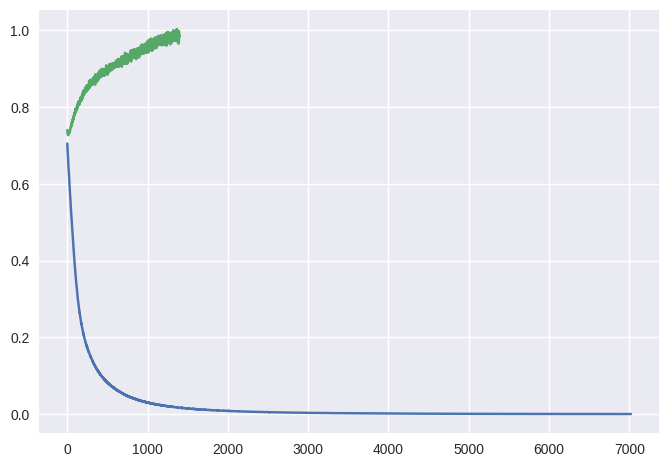

In [10]:
plt.plot(trainer.train_losses["discriminator"])
plt.plot(trainer.train_losses["generator"])